<a href="https://colab.research.google.com/github/DevashishPrasad/CascadeTabNet/blob/master/Demo/Cascade_TabNet_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CascadeTabNet Demo Notebook
[![PWC](https://img.shields.io/endpoint.svg?url=https://paperswithcode.com/badge/cascadetabnet-an-approach-for-end-to-end/table-detection-on-icdar2013-1)](https://paperswithcode.com/sota/table-detection-on-icdar2013-1?p=cascadetabnet-an-approach-for-end-to-end)
[![PWC](https://img.shields.io/badge/PyTorch-v1.4-blue)](https://pytorch.org/)
[![PWC](https://img.shields.io/badge/%20mmdetection%20-v1.2-blue)](https://github.com/open-mmlab/mmdetection)

> **CascadeTabNet: An approach for end to end table detection and structure recognition from image-based documents**<br>
> [Devashish Prasad](https://github.com/DevashishPrasad),
> [Ayan Gadpal](https://github.com/ayangadpal),
> [Kshitij Kapadni](https://github.com/kshitijkapadni),
> [Manish Visave](https://github.com/ManishDV),
> <br>
> [Preprint Link of Paper](https://arxiv.org/abs/2004.12629)<br>
> <a href="results.pdf">Supplementary file</a> <br>
> The paper has been accepted at [CVPR 2020 Workshop on Text and Documents in the Deep Learning Era](https://cvpr2020text.wordpress.com/)<br>
> [Code Link](https://github.com/DevashishPrasad/CascadeTabNet)
<img align="right" src="imgs/CVPR Teaser.gif" />

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


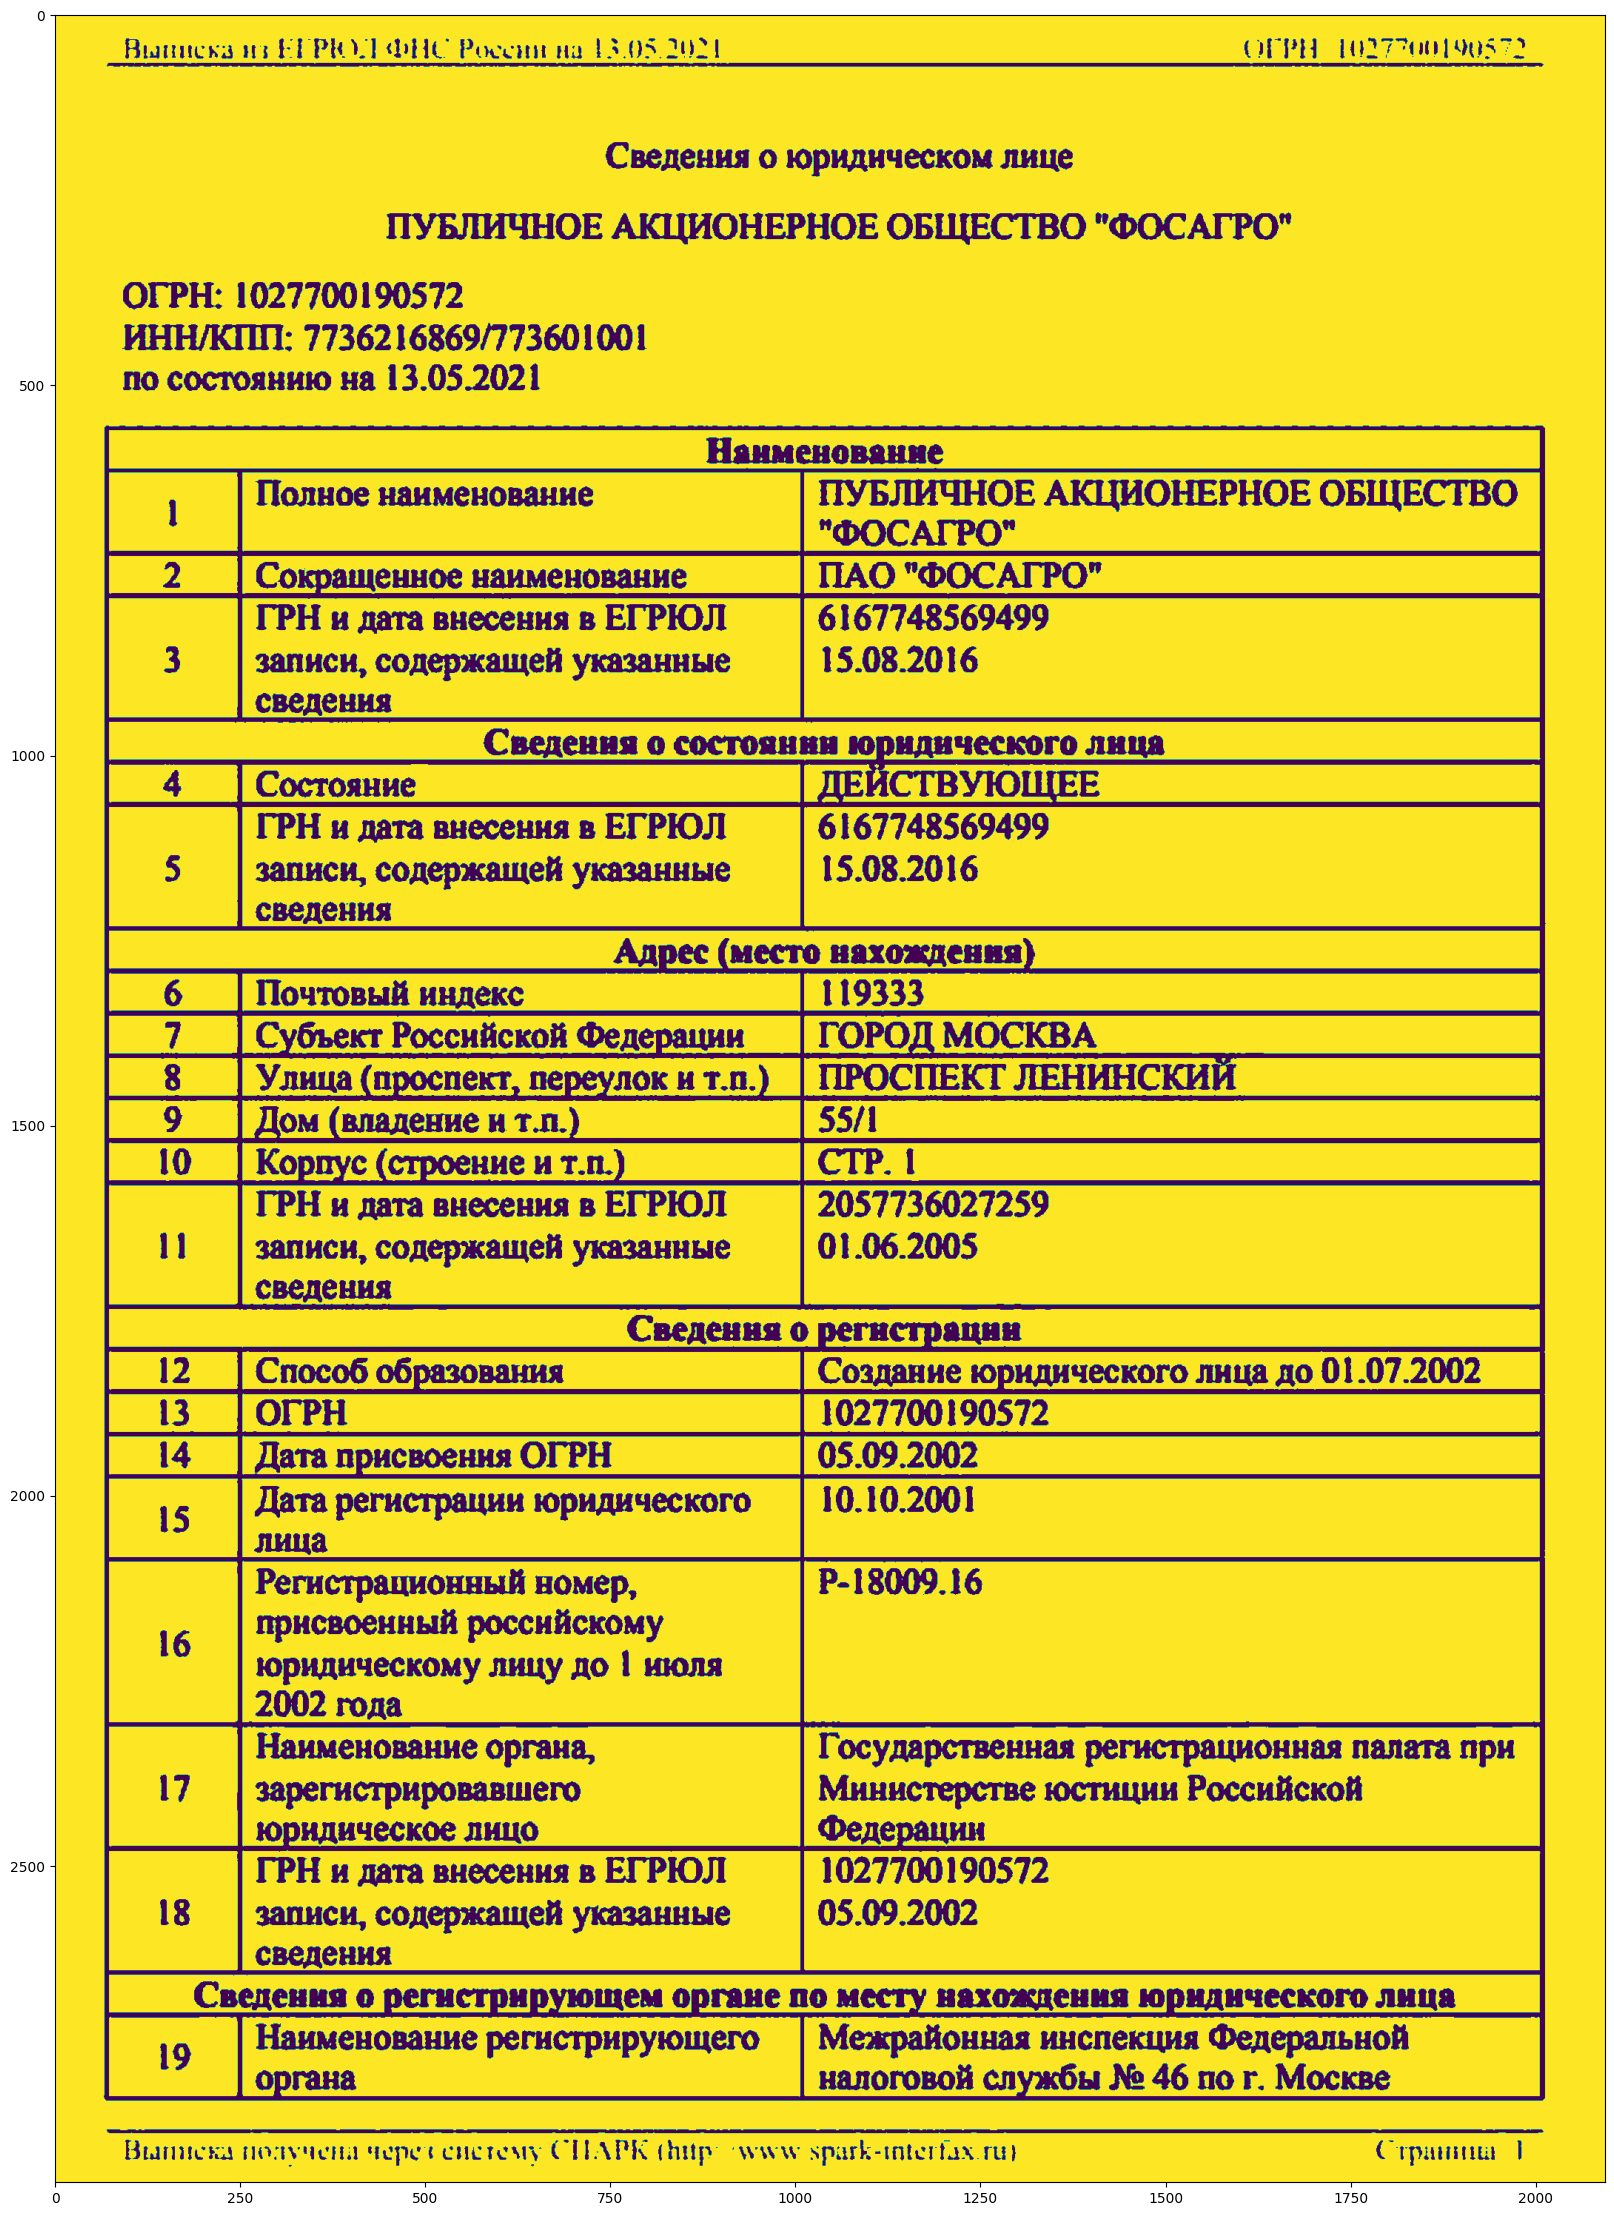

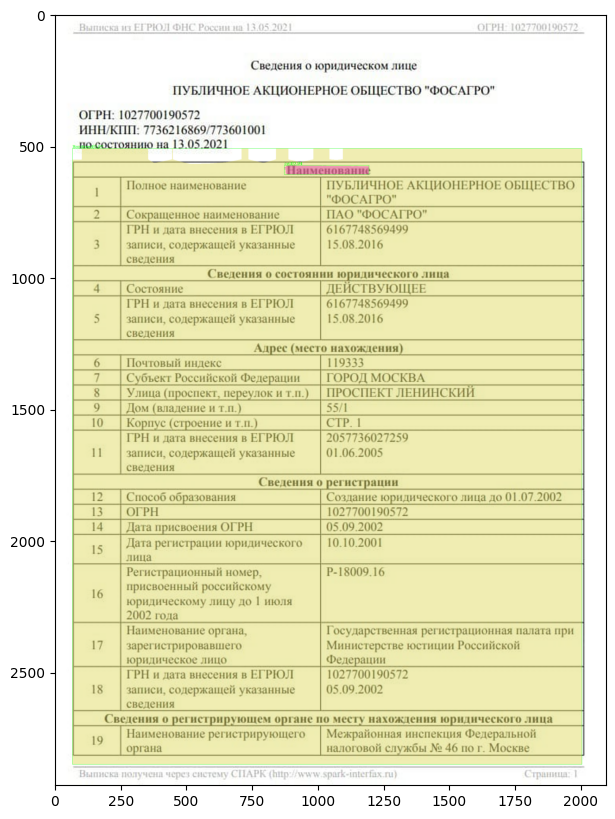

In [1]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract

# Load model
config_file = '/content/CascadeTabNet/Config/cascade_mask_rcnn_hrnetv2p_w32_20e.py'
checkpoint_file = '/content/epoch_36.pth'
model = init_detector(config_file, checkpoint_file, device='cuda:0')

# Test a single image 
path_ = "/content/photo_2021-05-16_15-52-29.jpg"
image = cv2.imread(path_)
div = 3000//image.shape[0]
image=cv2.resize(image,dsize=(image.shape[1]*div, image.shape[0]*div), interpolation=cv2.INTER_CUBIC)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.threshold(gray, 210, 255,cv2.THRESH_BINARY)[1]
#kernel = np.ones((3,3),np.uint8)
#gray = cv2.dilate(gray, kernel, iterations=3)
plt.figure(figsize=(20, 30))
plt.imshow(gray)
gray = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
#cv2.imwrite('img.png', image)
# Run Inference
result = inference_detector(model, gray)

# Visualization results
show_result_pyplot(image, result,('Bordered', 'cell', 'Borderless'), score_thr=0.85)

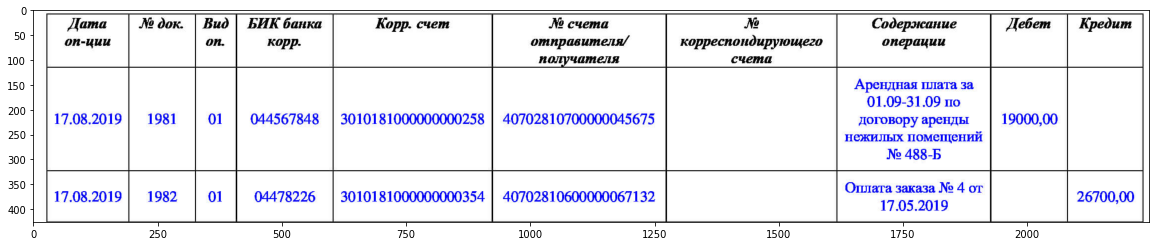

In [2]:
result = result[0]
full_border = len(result[0]) != 0
result = [x for x in result if len(x) !=0]
result = sorted(result, key=len)
res = [int(x) for x in result[0][0]]
table = image[res[1]:res[3],res[0]:res[2]]
cells = [[int(cell[0] - res[0]), int(cell[1] - res[1]),
          int(cell[2] - res[0]), int(cell[3] - res[1])] for cell in result[-1]]
cells = [cell for cell in cells if cell[0] >= 0 and cell[1] >=0]
plt.figure(figsize=(20, 30))
plt.imshow(table)

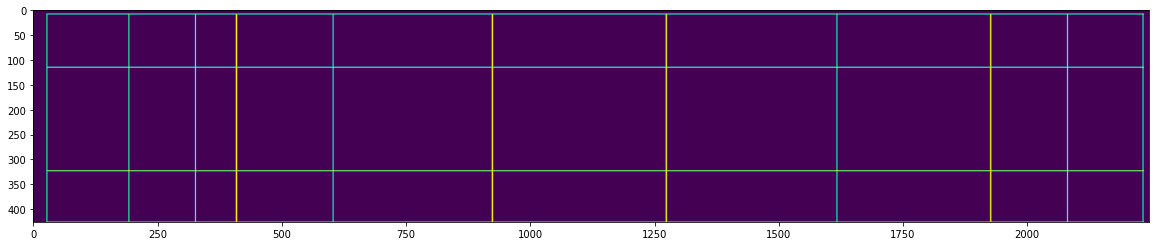

In [3]:
if full_border:
  img = table

  im = cv2.imread(path_)[res[1]//div:res[3]//div,res[0]//div:res[2]//div]
  im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
  dst = cv2.adaptiveThreshold(~im, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, -2)

  horizontal = dst.copy()
  vertical = dst.copy()
  scale = 13 # play with this variable in order to increase/decrease the amount of lines to be detected

  # Specify size on horizontal axis
  #print(horizontal.shape)
  horizontalsize = horizontal.shape[1] // scale
  horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontalsize, 1))
  horizontal = cv2.erode(horizontal, horizontalStructure, (-1, -1))
  horizontal = cv2.dilate(horizontal, horizontalStructure, (-1, -1))
  #plt.figure(figsize=(20, 30))
  #plt.imshow( horizontal)

  # vertical
  verticalsize = vertical.shape[0] // scale
  verticalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (1, verticalsize))
  vertical = cv2.erode(vertical, verticalStructure, (-1, -1))
  vertical = cv2.dilate(vertical, verticalStructure, (-1, -1))
  #plt.figure(figsize=(20, 30))
  #plt.imshow( vertical)

  # table line
  grid = horizontal + vertical

  plt.figure(figsize=(20, 30))
  plt.imshow(grid)

In [4]:
if not full_border:
  im = table.copy()
  gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
  im = cv2.threshold(im, 170, 255,cv2.THRESH_BINARY)[1]

  grid = np.zeros(im.shape, np.uint8)
  arr = np.zeros(im.shape[1])
  for cell in cells:
    #print(cell)
    arr[cell[0]:cell[2]] += 1

  start = 0
  end = 0
  intervals = []
  for i in range(len(arr)-1):
    if start is not None and (arr[i] == arr[i-1]) and arr[i+1] > arr[i]:
      end = i
      interval = int((end + start)/2)
      print(interval)
      cv2.line(grid, (interval, 0),
                    (interval, im.shape[0]), (255,255,255),3)
      start = None
    if arr[i-1] > arr[i] and arr[i+1] == arr[i]:
      start = i

  end = len(arr) - 1

  arr = np.zeros(im.shape[0])
  for cell in cells:
    #print(cell)
    arr[cell[1]:cell[3]] += 1

  start = 0
  end = 0
  intervals = []
  prev_start = arr[0]
  for i in range(1, len(arr)-1):
    if start is not None and (arr[i] == arr[i-1]) and arr[i+1] > arr[i]:
      end = i
      interval = int((end + start)/2)
      print(interval)
      cv2.line(grid, ( 0, interval),
                    (im.shape[1], interval), (0,255,0),3)
      start = None
    if arr[i-1] > arr[i] and arr[i+1] == arr[i]:
      start = i

  end = len(arr) - 1
  #interval = int((end + start)/2)
  cv2.line(grid, ( 0, im.shape[0]),
                    (im.shape[1], im.shape[0]), (0,255,0),3)

  plt.figure(figsize=(20, 30))
  plt.imshow(grid)

  grid = cv2.cvtColor(grid, cv2.COLOR_BGR2GRAY)

4
Результат:
Дата он-ции ||Вид |БИК банка корр. ||№ счета отправителя/ получателя |№  корреспондирующего счета   |Содержание операции ||
17.08.2019   |1981 ||044567848 |3010181000000000258   |40702810700000045675   ||Арендная плата за 01.09-31.09 по  договору аренды нежилых помещений № 488-Б   |19000,00 |
17.08.2019 |1982 ||04478226 |3010181000000000354 |40702810600000067132 || ||26700,00 


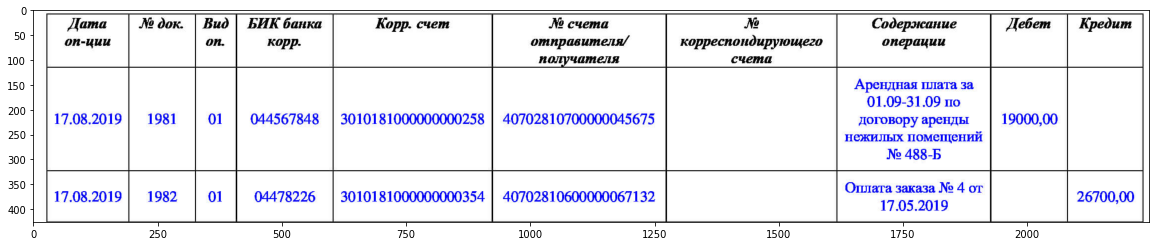

In [5]:

contours,hierarchy = cv2.findContours(grid,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

# For each contour, find the bounding rectangle and draw it
cells = []
for cnt in contours:
  x,y,w,h = cv2.boundingRect(cnt)

  if w < 0.9*grid.shape[1] and h < 0.95*grid.shape[0]:
    cells.append((x, y, w, h))
    #print(x, y, w, h)
    #cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),1)

#print(sorted(lines, key=lambda x: x[0]))
img = table.copy()#cv2.imread(path_)
div1 = 12000//3000
div *= div1
print(div)
image=cv2.resize(img,dsize=(img.shape[1]*div1, img.shape[0]*div1), interpolation=cv2.INTER_CUBIC)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.threshold(gray, 170, 255,
cv2.THRESH_BINARY)[1]

i=0

clusters = []
for cl in sorted(cells, key=lambda x: (x[1])):
  if cl[2] < 5 or cl[3] < 5:
    continue
  if len(clusters) == 0:
    clusters.append([cl])
  elif abs(cl[1] - clusters[-1][0][1]) < 3 :
    clusters[-1].append(cl) 
  else:
    clusters.append([cl])

res_text = []
for cluster in clusters:
  cluster = sorted(cluster, key=lambda x: (x[0]))
  cur_text = []
  for (x, y, w, h) in cluster:
    cell_ = image[y*div:y*div+h*div, x*div:x*div+w*div]
    text = ' '.join([phrase.strip() for phrase in pytesseract.image_to_string(cell_, lang='rus').split('\n')])
    #print(text)
    cur_text.append(text)
  res_text.append('|'.join(cur_text))

print('Результат:')
for s in res_text:
  print(s)
plt.figure(figsize=(20, 30))
(x, y, w, h) = (161, 152, 114, 19)
plt.imshow(img)#[y*div:y*div+h*div, x*div:x*div+w*div])

In [8]:
res_text

['Дата он-ции ||Вид |БИК банка корр. ||№ счета отправителя/ получателя |№  корреспондирующего счета   |Содержание операции ||',
 '|:----------------:|:----------------:|:----------------:|:----------------:|:----------------:|:----------------:|:----------------:|:----------------:|:----------------:|:----------------:|',
 '17.08.2019   |1981 ||044567848 |3010181000000000258   |40702810700000045675   ||Арендная плата за 01.09-31.09 по  договору аренды нежилых помещений № 488-Б   |19000,00 |',
 '17.08.2019 |1982 ||04478226 |3010181000000000354 |40702810600000067132 || ||26700,00 ']

In [6]:
n = len(res_text[0].split('|'))
add_str = ''.join(["|:----------------:" for x in range(n)]) + '|'
res_text.insert(1, add_str)

In [7]:
'\n'.join([('|' + x + '|').replace('||', '|  |').replace('|', '| ')  if i != 1 else x  for (i, x) in enumerate(res_text)])

'| Дата он-ции |   | Вид | БИК банка корр. |   | № счета отправителя/ получателя | №  корреспондирующего счета   | Содержание операции |   | | \n|:----------------:|:----------------:|:----------------:|:----------------:|:----------------:|:----------------:|:----------------:|:----------------:|:----------------:|:----------------:|\n| 17.08.2019   | 1981 |   | 044567848 | 3010181000000000258   | 40702810700000045675   |   | Арендная плата за 01.09-31.09 по  договору аренды нежилых помещений № 488-Б   | 19000,00 |   | \n| 17.08.2019 | 1982 |   | 04478226 | 3010181000000000354 | 40702810600000067132 |   |  |   | 26700,00 | '

In [20]:
import pandas as pd
pd.DataFrame([x.split('|') for x in res_text])

,0,1,2,3,4,5,6,7,8,9
0,Дата он-ции,,Вид,БИК банка корр.,,№ счета отправителя/ получателя,№ корреспондирующего счета,Содержание операции,,
1,17.08.2019,1981,,044567848,3010181000000000258,40702810700000045675,,Арендная плата за 01.09-31.09 по договору аре...,"19000,00",
2,17.08.2019,1982,,04478226,3010181000000000354,40702810600000067132,,,,"26700,00"


# Cite as
If you find this work useful for your research, please cite our paper:

```
@misc{ cascadetabnet2020,
    title={CascadeTabNet: An approach for end to end table detection and structure recognition from image-based documents},
    author={Devashish Prasad and Ayan Gadpal and Kshitij Kapadni and Manish Visave and Kavita Sultanpure},
    year={2020},
    eprint={2004.12629},
    archivePrefix={arXiv},
    primaryClass={cs.CV}
}
```
